In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import geopandas as gpd
import rioxarray as rxr
import yaml
from rasterio.plot import plotting_extent

# Seabee AI snippet



Detect on realfagsbygget

In [5]:
model = "detection/2022_nina_birds_20230817"
root_path = "./nrdata"
input_path = f"{root_path}/input"
mission_name = "Bergen_Realfagstaket_20230530"
orthophoto_file = f"seabirds/2023/{mission_name}/orthophoto/{mission_name}.tif"


Set these env variables if using minio for remote access
```env
MINIO_ACCESS_KEY=[KEY]
MINIO_SECRET_KEY=[KEY]
MINIO_BUCKET_MODELS=models
MINIO_URL=https://storage.seabee.sigma2.no
```

and install the seabee ai repo with the cell below if this is the first time


In [13]:
%%bash
git clone git@github.com:SeaBee-no/seabee-ai.git
cd seabee-ai
pip install -U .
pip install -U minio torch torchvision

fatal: destination path 'seabee-ai' already exists and is not an empty directory.


Processing /home/kim/work/seabee/snippets/seabee-ai
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached albumentations-1.3.1-py3-none-any.whl (125 kB)
  Using cached geopandas-0.14.0-py3-none-any.whl (1.1 MB)
  Using cached opencv_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.7 MB)
  Using cached pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (426 kB)
  Using cached shapely-2.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.5 MB)
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
  Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
  Using cached tensorboard-2.15.1-py3-none-any.whl (5.5 MB)
  Using cached scipy-1.11.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.4 MB)
  Using cached scikit_image-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.7 MB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  


[notice] A new release of pip is available: 23.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 1.9 MB/s eta 0:00:00
  Using cached torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl (670.2 MB)
  Using cached torchvision-0.16.0-cp310-cp310-manylinux1_x86_64.whl (6.9 MB)
  Using cached argon2_cffi-23.1.0-py3-none-any.whl (15 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.1 MB/s eta 0:00:00
  Using cached filelock-3.13.1-py3-none-any.whl (11 kB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached fsspec-2023.10.0-py3-none-any.whl (166 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-1


[notice] A new release of pip is available: 23.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## Create configurations

`hub.yaml` configures the program and paths for the hub. We don't have a gpu on the hub and data is mounted so we can skip minio.

In [14]:
%%bash
mkdir config

cat <<EOF >./config/hub.yaml
DPATH_WORK: ./nrdata/work
DPATH_MODELS: ./nrdata/models
DPATH_RESULTS: ./nrdata/results
DPATH_PRETRAINED: ./nrdata/pretrained
MINIO:
    USE: true
TEST:
    DEVICE: cpu
EOF

mkdir: cannot create directory ‘config’: File exists


`image_detection.yaml` configures the program for training or detection on various images. For the hub we use detection in production mode.

In [6]:
%%bash -s "$model" "$input_path" "$orthophoto_file"

cat <<EOF >./config/image_detection.yaml
mode: production
task: detection
score_threshold: 0.1  # For use in test mode only
model:
    id: $1
dataset:
    root: $2
    # NOTE: Filenames are extracted from the annotation.csv file if annotations are provided, else we use test_filenames
    # NOTE: Using tif's src.descriptions to extract red, green and blue channels
    annotations:
#       csv: None
        crs: "epsg:4326"
        column_main_class: species
        columns_subtasks: [activity,sex,age]
    test_filenames: 
      - $3
EOF

## Run the bird detection

1. preprocess the images

In [19]:
%%bash
nrseabee_det_preproc -c config/hub.yaml -o config/nrseabee_det_preproc.yaml config/image_detection.yaml

Created log file: nrdata/work/dataset/LOG_preprocess.txt
Started: 20231110-101339

 file: nrdata/input/seabirds/2023/Bergen_Realfagstaket_20230530/orthophoto/Bergen_Realfagstaket_20230530.tif
 spatial sample rate: 7.810357668882609 mm x 7.810362387056105 mm
x_res: 0.0078103576688826086
y_res: 0.0078103623870561046
scale_factor_x: 1.5620715337765216
scale_factor_y: 1.562072477411221
height: 23795
width: 25121
 original data of shape (23795, 25121) re-sampled to (37169, 39240)
 Doing tile row 1/13
 saving nrdata/work/dataset/images/seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_1.jpg and the accompanying .jgw
Save complete
 saving nrdata/work/dataset/images/seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_2.jpg and the accompanying .jgw
Save complete
 saving nrdata/work/dataset/images/seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_3.jpg and the accompanying .j

2. start the detection run, (this can take some time)

In [20]:
%%bash
nrseabee_det_test -c config/hub.yaml -o config/nrseabee_det_test.yaml config/nrseabee_det_preproc.yaml

MINIO_ACCESS_KEY must be set to access Minio
Predictions to be saved in nrdata/results/detection/2022_nina_birds_20230817/2023-11-10-1015
 eta 0.0 minutes | image_id 001 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_1.jpg
 eta 42.0 minutes | image_id 002 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_2.jpg
 eta 55.0 minutes | image_id 003 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_3.jpg
 eta 61.6 minutes | image_id 004 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_4.jpg
 eta 65.4 minutes | image_id 005 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_5.jpg
 eta 67.6 minutes | image_id 006 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_6.jpg
 eta 69.5 minutes | image_id 007 / 

 eta 72.2 minutes | image_id 016 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_2_2.jpg
 eta 73.2 minutes | image_id 017 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_2_3.jpg
 eta 72.7 minutes | image_id 018 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_2_4.jpg
 eta 72.0 minutes | image_id 019 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_2_5.jpg
 eta 71.7 minutes | image_id 020 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_2_6.jpg
 eta 71.2 minutes | image_id 021 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_2_7.jpg
 eta 70.5 minutes | image_id 022 / 182 | seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_2_8.jpg
 eta 70.3 minutes | image_id 023 /

3. generate the geopackage with detections

In [11]:
%%bash -s $mission_name

nrseabee_det_postproc -c config/hub.yaml -o config/$1_postproc.yaml config/nrseabee_det_test.yaml

wrote   nrdata/results/detection/2022_nina_birds_20230817/2023-11-10-1051/out.csv
 .. and nrdata/results/detection/2022_nina_birds_20230817/2023-11-10-1051/out.gpkg


In [9]:

with open(f"config/{mission_name}_postproc.yaml", "r") as f:
    post_conf = yaml.safe_load(f)
post_conf

{'dataset': {'annotations': {'column_main_class': 'species',
   'columns_subtasks': ['activity', 'sex', 'age'],
   'crs': 'epsg:4326'},
  'fn_patch_to_org_filename': ['seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_1.jpg::::seabirds/2023/Bergen_Realfagstaket_20230530/orthophoto/Bergen_Realfagstaket_20230530.tif',
   'seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_2.jpg::::seabirds/2023/Bergen_Realfagstaket_20230530/orthophoto/Bergen_Realfagstaket_20230530.tif',
   'seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_3.jpg::::seabirds/2023/Bergen_Realfagstaket_20230530/orthophoto/Bergen_Realfagstaket_20230530.tif',
   'seabirds_2023_Bergen_Realfagstaket_20230530_orthophoto_Bergen_Realfagstaket_20230530_tif_1_4.jpg::::seabirds/2023/Bergen_Realfagstaket_20230530/orthophoto/Bergen_Realfagstaket_20230530.tif',
   'seabirds_2023_Bergen_Realfagstaket_20230530_orthopho

In [10]:
df_birds =  gpd.read_file(f"{post_conf['dpath_results']}/out.gpkg").to_crs(32631)
df_birds.head()

,id,score_species,score_activity,score_sex,score_age,fileid,individualid,datetimereg,visibleonimage,comment,modelversion,manuallyverified,species,activity,sex,age,TEMP_image_filename,geometry
0,1,0.351338,0.984965,0.651981,0.998223,-1,1,2023-11-10 13:04:21,True,,1,False,2570,4,1,3,seabirds/2023/Bergen_Realfagstaket_20230530/or...,"POLYGON ((628288.640 6696627.927, 628288.640 6..."
1,2,0.303579,0.572083,0.588375,0.995809,-1,2,2023-11-10 13:04:21,True,,1,False,9225,3,1,3,seabirds/2023/Bergen_Realfagstaket_20230530/or...,"POLYGON ((628293.371 6696624.323, 628293.371 6..."
2,3,0.179449,0.787798,0.583441,0.986935,-1,3,2023-11-10 13:04:21,True,,1,False,590,3,1,3,seabirds/2023/Bergen_Realfagstaket_20230530/or...,"POLYGON ((628291.919 6696623.330, 628291.919 6..."
3,4,0.352937,0.594171,0.611761,0.988964,-1,4,2023-11-10 13:04:21,True,,1,False,2630,3,1,3,seabirds/2023/Bergen_Realfagstaket_20230530/or...,"POLYGON ((628266.478 6696615.355, 628266.478 6..."
4,5,0.984858,0.989929,0.756294,0.999464,-1,5,2023-11-10 13:04:21,True,,1,False,2570,1,1,3,seabirds/2023/Bergen_Realfagstaket_20230530/or...,"POLYGON ((628292.496 6696613.709, 628292.496 6..."


In [11]:
raster = rxr.open_rasterio(f"{input_path}/{orthophoto_file}").squeeze()
raster

<xarray.DataArray (band: 3, y: 23795, x: 25121)>
[1793262585 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 6.282e+05 6.282e+05 ... 6.284e+05 6.284e+05
  * y            (y) float64 6.697e+06 6.697e+06 ... 6.696e+06 6.696e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_APPROXIMATE:    YES
    STATISTICS_MAXIMUM:        254
    STATISTICS_MEAN:           54.955233642259
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         37.231653580159
    STATISTICS_VALID_PERCENT:  49.41
    _FillValue:                255
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 ('red', 'green', 'blue')

## Plot data

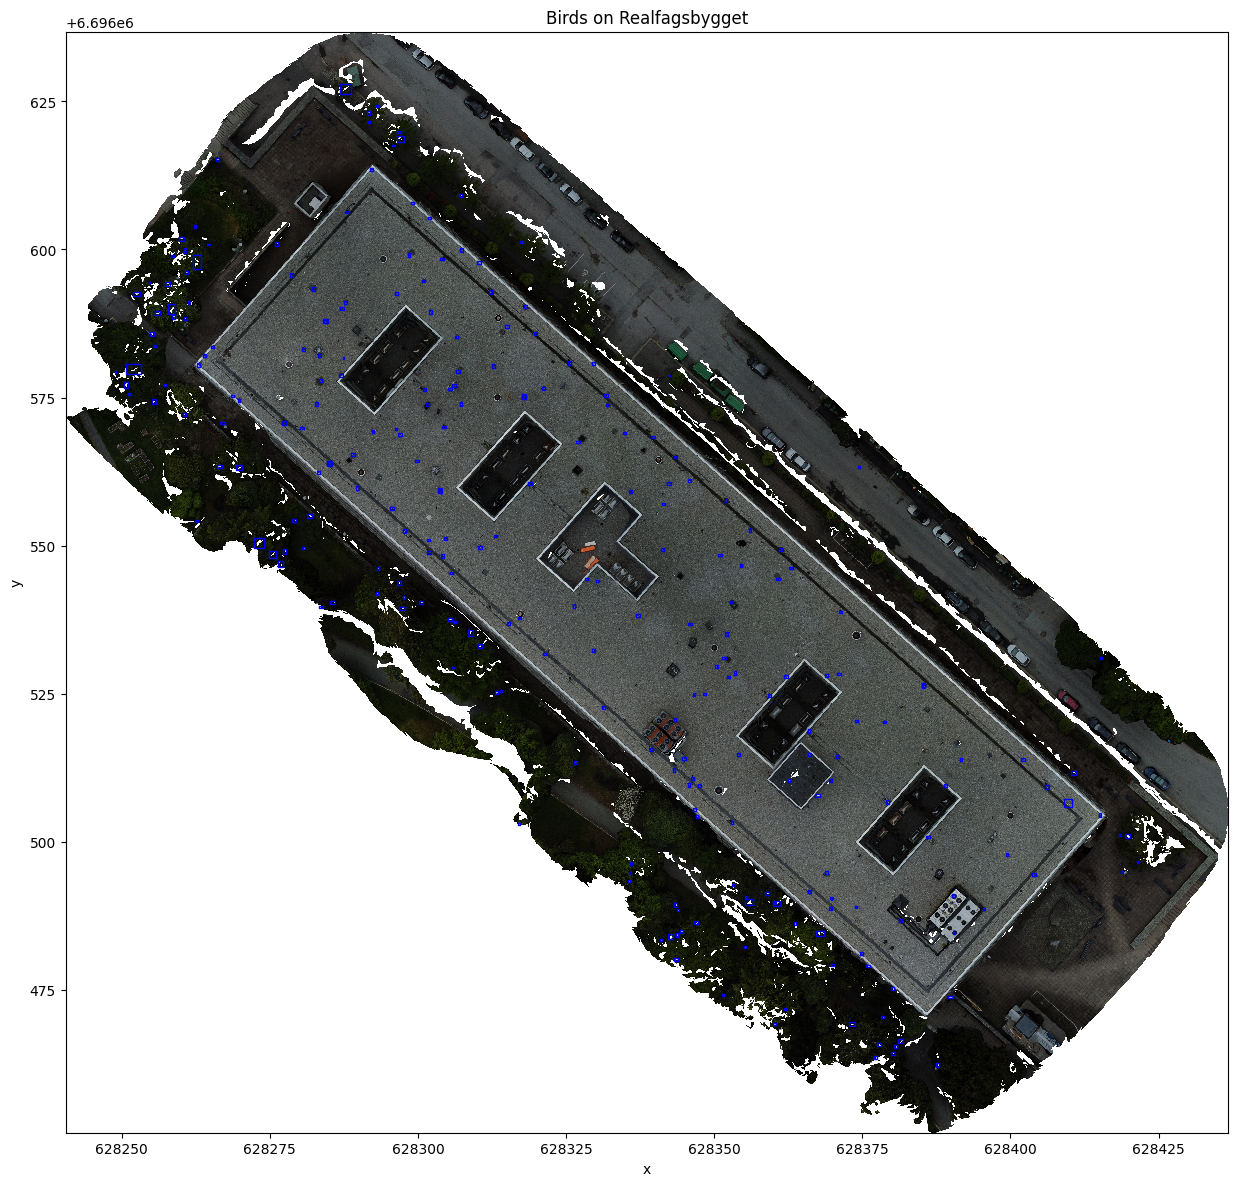

In [13]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_extent = plotting_extent(raster[0], raster.rio.transform())
raster.plot.imshow(ax=ax, extend=plot_extent)
df_birds.plot(ax=ax, facecolor="none", edgecolor="blue", linewidth=1)
plt.title("Birds on Realfagsbygget")
plt.show()